### Generating Data

Below we choose 100 different starting points for the Lorenz system and calculate the trajectory for 8 seconds in time. We will use this to train our neural network. This will allow the network to act as a time-stepper : given a point (x,y,z) it can calculate the new point (x', y', z') dt seconds further in time.

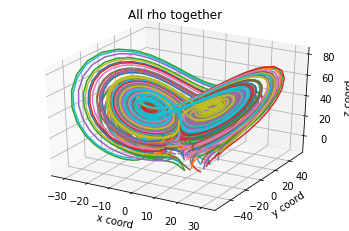

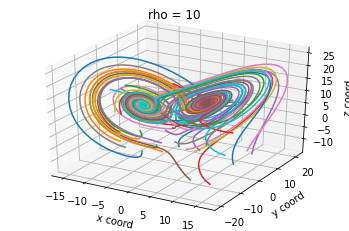

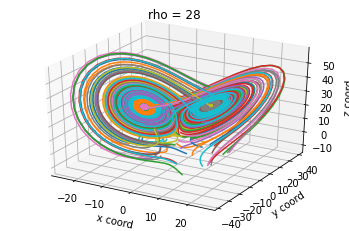

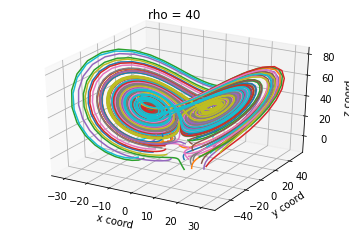

In [ ]:
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np
import scipy.integrate
from mpl_toolkits.mplot3d import Axes3D


dt = 0.01  # time step size
T = 8  # total simulation time per initial condition
t = np.arange(start=0, stop=T, step=dt)
num_trajectories = 50  # number of trajectories to simulate (at each rho)

# Set parameters of the lorenz system (rho set later)
b = 8/3
sig = 10


def lorenz(t, x, rho):
    global b, sig
    return [sig * (x[1] - x[0]),  rho * x[0] - x[0]*x[2] - x[1], x[0]*x[1] - b*x[2]]

all_fig = plt.figure(0)
all_ax = all_fig.gca(projection='3d')
plt.xlabel('x coord')
plt.ylabel('y coord')
all_ax.set_zlabel('z coord')
plt.title('All rho together')

for i, rho in enumerate([10, 28, 40]): # 10, 28, 40
    fig = plt.figure(i+1)
    ax = fig.gca(projection='3d')
    for j in range(num_trajectories):
        x0 = 30*np.random.uniform(low=-0.5, high=0.5, size=3)

        # Pass in initial conditions and relative/absolute tolerance
        y_vals = scipy.integrate.odeint(func = lambda t,x: lorenz(t,x, rho), y0=x0, t=t, rtol=1e-10, atol=1e-11, tfirst=True)
        
        
        if j == 0 and i == 0:
            inputs = y_vals[:-1, :]
            outputs = y_vals[1:, :]
        else:
            inputs = np.vstack((inputs, y_vals[:-1, :]))
            outputs = np.vstack((outputs, y_vals[1:, :]))

        ax.plot(xs=y_vals[:, 0], ys=y_vals[:, 1], zs=y_vals[:, 2])
        all_ax.plot(xs=y_vals[:, 0], ys=y_vals[:, 1], zs=y_vals[:, 2])


    plt.xlabel('x coord')
    plt.ylabel('y coord')
    ax.set_zlabel('z coord')
    plt.title('rho = ' + str(rho))
    
plt.show(block=True)


# Inputs stores the (x,y,z) at each time t and Outputs stores the (x,y,z) at each time (t+1) ; the two are just staggered


### Training A neural Network

Here we define a standard 3-layer feedforward neural network with 20 neurons in each layer

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

l1 = 0
l2 = 0

# can define a custom activation function and pass it as a parameter with 'activation' as well. 
model = Sequential()
model.add(Dense(40, activation='relu', kernel_regularizer = regularizers.l1_l2(l1=l1, l2=l2), input_shape = (3,)))
model.add(Dense(40, activation='relu',  kernel_regularizer = regularizers.l1_l2(l1=l1, l2=l2)))
model.add(Dense(40, activation='linear',  kernel_regularizer = regularizers.l1_l2(l1=l1, l2=l2)))
model.add(Dense(40, activation='tanh',  kernel_regularizer = regularizers.l1_l2(l1=l1, l2=l2)))
model.add(Dense(3, activation='linear'))

model.compile(optimizer='rmsprop', loss='mean_squared_error')


In [ ]:
model.fit(inputs, outputs, 
         epochs=1000,
         batch_size=1000,
         shuffle=True, 
         validation_split = 0.2) # use 20 % of data as a validation dataset

Epoch 1/1000
96/96 [==============================] - 1s 4ms/step - loss: 128.0417 - val_loss: 315.3115
Epoch 2/1000
96/96 [==============================] - 0s 3ms/step - loss: 91.7945 - val_loss: 254.5515
Epoch 3/1000
96/96 [==============================] - 0s 3ms/step - loss: 69.0881 - val_loss: 201.9343
Epoch 4/1000
96/96 [==============================] - 0s 2ms/step - loss: 50.8357 - val_loss: 157.7999
Epoch 5/1000
96/96 [==============================] - 0s 3ms/step - loss: 36.6899 - val_loss: 120.8801
Epoch 6/1000
96/96 [==============================] - 0s 3ms/step - loss: 26.1629 - val_loss: 91.8945
Epoch 7/1000
96/96 [==============================] - 0s 2ms/step - loss: 18.7355 - val_loss: 69.7909
Epoch 8/1000
96/96 [==============================] - 0s 2ms/step - loss: 13.7079 - val_loss: 53.4037
Epoch 9/1000
96/96 [==============================] - 0s 2ms/step - loss: 10.4865 - val_loss: 42.0224
Epoch 10/1000
96/96 [==============================] - 0s 2ms/step - loss: 8

### Analyzing Training

Analyze the loss of the neural net (on both the training and validation datasets) as a function of epochs

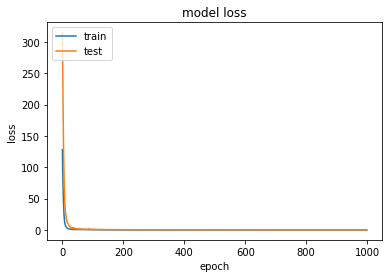

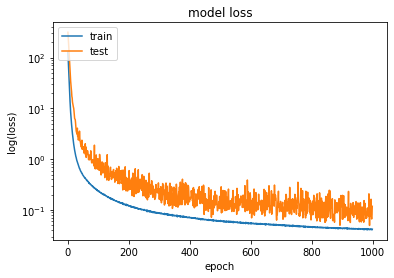

In [ ]:
%matplotlib inline

# summarize history for loss
plt.figure(2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.figure(3)
plt.semilogy(model.history.history['loss'])
plt.semilogy(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('log(loss)')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')



### Test Performance of Neural Net

Here, we will generate new trajectories using a random starting condition. Using both an ode solver and our neural network, we will predict the trajectories of the points.

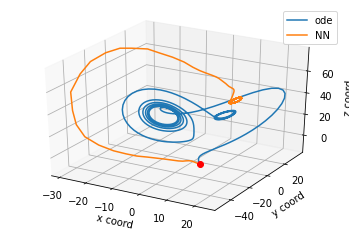

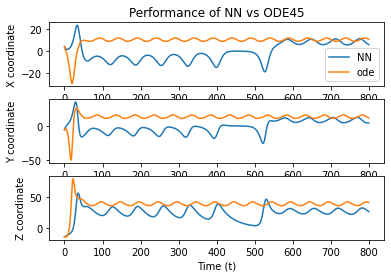

In [ ]:
%matplotlib inline

# Predicting on rho = 28 (in the training data)

y0 = 30*np.random.uniform(low=-0.5, high=0.5, size=3)

rho = 28

y_ode = scipy.integrate.odeint(func= lambda t,x: lorenz(t,x, rho), y0=y0, t=t, rtol=1e-10, atol=1e-11, tfirst=True)

y_NN = np.zeros(y_ode.shape)
y_NN[0, :] = y0


for i in range(1, y_NN.shape[0]):
    y_NN[i, :] = model.predict(np.expand_dims(y_NN[i-1, :], axis=1).T)

    
fig = plt.figure(4)
ax = fig.gca(projection='3d')

ax.plot(xs=y_ode[:, 0], ys=y_ode[:, 1], zs=y_ode[:, 2])
ax.plot(xs=y_NN[:, 0], ys=y_NN[:, 1], zs=y_NN[:, 2])
ax.plot([y0[0]], [y0[1]], [y0[2]], 'ro')
ax.legend(['ode', 'NN'])
plt.xlabel('x coord')
plt.ylabel('y coord')
ax.set_zlabel('z coord')

# PLOT X,Y, Z over time for both NN and ode

plt.figure()
plt.subplot(311)
plt.plot(y_ode[:, 0])
plt.plot(y_NN[:, 0])
plt.legend(['NN', 'ode'])
plt.ylabel('X coordinate')
plt.title('Performance of NN vs ODE45')

plt.subplot(312)
plt.plot(y_ode[:, 1])
plt.plot(y_NN[:, 1])
plt.ylabel('Y coordinate')

plt.subplot(313)
plt.plot(y_ode[:, 2])
plt.plot(y_NN[:, 2])
plt.ylabel('Z coordinate')
plt.xlabel('Time (t)')

plt.show()

    


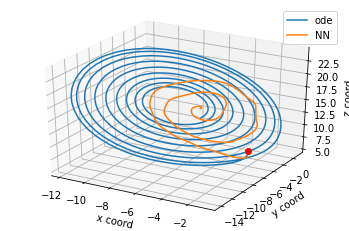

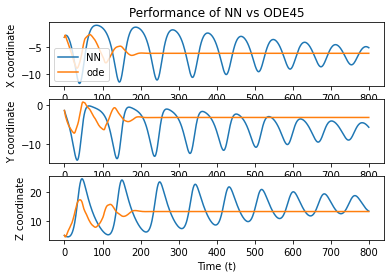

In [ ]:
%matplotlib inline

# Predicting on rho = 17 (outside the training data)

y0 = 30*np.random.uniform(low=-0.5, high=0.5, size=3) # choose a random initial condition

rho = 17

y_ode = scipy.integrate.odeint(func= lambda t,x: lorenz(t,x, rho), y0=y0, t=t, rtol=1e-10, atol=1e-11, tfirst=True)

y_NN = np.zeros(y_ode.shape)
y_NN[0, :] = y0


for i in range(1, y_NN.shape[0]):
    y_NN[i, :] = model.predict(np.expand_dims(y_NN[i-1, :], axis=1).T)

# Plot 3D prediction
fig = plt.figure(4)
ax = fig.gca(projection='3d')

ax.plot(xs=y_ode[:, 0], ys=y_ode[:, 1], zs=y_ode[:, 2])
ax.plot(xs=y_NN[:, 0], ys=y_NN[:, 1], zs=y_NN[:, 2])
ax.plot([y0[0]], [y0[1]], [y0[2]], 'ro')
ax.legend(['ode', 'NN'])
plt.xlabel('x coord')
plt.ylabel('y coord')
ax.set_zlabel('z coord')

# PLOT X,Y, Z over time for both NN and ode

plt.figure()
plt.subplot(311)
plt.plot(y_ode[:, 0])
plt.plot(y_NN[:, 0])
plt.legend(['NN', 'ode'])
plt.ylabel('X coordinate')
plt.title('Performance of NN vs ODE45')

plt.subplot(312)
plt.plot(y_ode[:, 1])
plt.plot(y_NN[:, 1])
plt.ylabel('Y coordinate')

plt.subplot(313)
plt.plot(y_ode[:, 2])
plt.plot(y_NN[:, 2])
plt.ylabel('Z coordinate')
plt.xlabel('Time (t)')

plt.show()

    


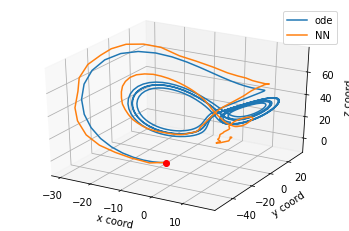

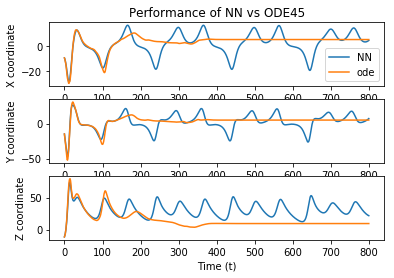

In [ ]:
%matplotlib inline

# Predicting on rho = 35 (outside the training data)

y0 = 30*np.random.uniform(low=-0.5, high=0.5, size=3)

rho = 35

y_ode = scipy.integrate.odeint(func= lambda t,x: lorenz(t,x, rho), y0=y0, t=t, rtol=1e-10, atol=1e-11, tfirst=True)

y_NN = np.zeros(y_ode.shape)
y_NN[0, :] = y0


for i in range(1, y_NN.shape[0]):
    y_NN[i, :] = model.predict(np.expand_dims(y_NN[i-1, :], axis=0))

# PLOT 3D prediction
fig = plt.figure(4)
ax = fig.gca(projection='3d')

ax.plot(xs=y_ode[:, 0], ys=y_ode[:, 1], zs=y_ode[:, 2])
ax.plot(xs=y_NN[:, 0], ys=y_NN[:, 1], zs=y_NN[:, 2])
ax.plot([y0[0]], [y0[1]], [y0[2]], 'ro')
ax.legend(['ode', 'NN'])
plt.xlabel('x coord')
plt.ylabel('y coord')
ax.set_zlabel('z coord')


# PLOT X,Y, Z over time for both NN and ode

plt.figure()
plt.subplot(311)
plt.plot(y_ode[:, 0])
plt.plot(y_NN[:, 0])
plt.legend(['NN', 'ode'])
plt.ylabel('X coordinate')
plt.title('Performance of NN vs ODE45')

plt.subplot(312)
plt.plot(y_ode[:, 1])
plt.plot(y_NN[:, 1])
plt.ylabel('Y coordinate')

plt.subplot(313)
plt.plot(y_ode[:, 2])
plt.plot(y_NN[:, 2])
plt.ylabel('Z coordinate')
plt.xlabel('Time (t)')

plt.show()


    


### Training a Neural Network to recognize the time between lobe transitions

We noticed that a good separating plane between the two lobes was the plane x = 0. We used this benchmark to determine when a lobe transition occured. We have the neural network predict the number of time steps before a lobe transition occurs

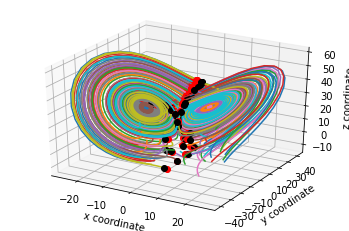

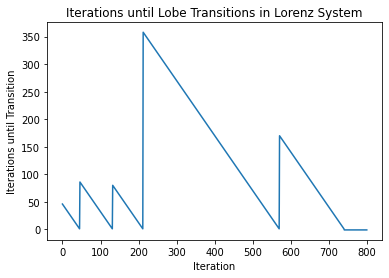

In [ ]:
fig = plt.figure(77)
ax = fig.gca(projection='3d')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
ax.set_zlabel('z coordinate')
num_trajectories = 100
rho = 28

for j in range(num_trajectories):
    x0 = 30*np.random.uniform(low=-0.5, high=0.5, size=3)

    # Pass in initial conditions and relative/absolute tolerance
    y_vals = scipy.integrate.odeint(func = lambda t,x: lorenz(t,x, rho), y0=x0, t=t, rtol=1e-10, atol=1e-11, tfirst=True)
    
    # transition occurs when x goes from positive to negative or vice versa. This only occurs when x(t) + x(t+1) = 0
    xs = np.sign(y_vals[:, 0]) # 1 when x is positive and -1 when its negative
    transitions = np.where(((xs[:-1] + xs[1:]) == 0 ))[0] # indices where a lobe transition occurs (index right before transition)
    dist_from_trans = np.zeros((1, len(t)))
    
    for i, ind in enumerate(transitions):
        if i == 0:
            dist_from_trans[0, :transitions[0] + 1] = list(range(transitions[0] + 1, 0, -1))
        else:
            dist_from_trans[0, transitions[i-1]+1:transitions[i]+1] = list(range(transitions[i] - transitions[i-1], 0, -1))
            
    # all points after last transition are set to -1
    dist_from_trans[0, transitions[-1] + 1:] = -1
    
    transition_times = np.expand_dims(((xs[:-1] + xs[1:]) == 0 ).astype(int), axis=0)
    
    # Train on either the transition points (i.e time right before transition) or the time to transitions. The two can easily 
    # be interconverted.
    
    train_on = 100* transition_times # multiply by 100 so MSE actually cares about getting these numbers right
    inputs = y_vals[:-1, :]
    
    if j == 0:
        lobe_inputs = inputs
        lobe_outputs = train_on.T
    else:
        lobe_inputs = np.vstack((lobe_inputs, inputs))
        lobe_outputs = np.vstack((lobe_outputs, train_on.T))

    ax.plot(xs=y_vals[:, 0], ys=y_vals[:, 1], zs=y_vals[:, 2])
    ax.plot(y_vals[transitions, 0], y_vals[transitions, 1], y_vals[transitions, 2], 'ro')
    ax.plot(y_vals[transitions + 1, 0], y_vals[transitions + 1, 1], y_vals[transitions + 1, 2], 'ko')
    

# plot on example of dist_from_trans

plt.figure()
plt.plot(dist_from_trans[0, :])
plt.xlabel('Iteration')
plt.ylabel('Iterations until Transition')
plt.title('Iterations until Lobe Transitions in Lorenz System')
plt.show()




In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# can define a custom activation function and pass it as a parameter with 'activation' as well. 
model = Sequential()
model.add(Dense(100, activation='linear', input_shape = (3,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
model.fit(lobe_inputs, lobe_outputs, 
         epochs=100,
         batch_size=100,
         shuffle=True, 
         validation_split = 0.2) # use 20 % of data as a validation dataset

Epoch 1/100
640/640 [==============================] - 2s 3ms/step - loss: 33.3725 - val_loss: 28.2789
Epoch 2/100
640/640 [==============================] - 2s 2ms/step - loss: 25.6282 - val_loss: 33.4428
Epoch 3/100
640/640 [==============================] - 2s 2ms/step - loss: 20.6787 - val_loss: 23.0295
Epoch 4/100
640/640 [==============================] - 2s 3ms/step - loss: 15.7117 - val_loss: 10.7434
Epoch 5/100
640/640 [==============================] - 2s 2ms/step - loss: 13.3059 - val_loss: 31.2645
Epoch 6/100
640/640 [==============================] - 2s 2ms/step - loss: 14.5890 - val_loss: 15.6273
Epoch 7/100
640/640 [==============================] - 1s 2ms/step - loss: 12.3843 - val_loss: 5.7141
Epoch 8/100
640/640 [==============================] - 2s 3ms/step - loss: 9.8453 - val_loss: 7.1259
Epoch 9/100
640/640 [==============================] - 2s 3ms/step - loss: 12.7566 - val_loss: 8.7261
Epoch 10/100
640/640 [==============================] - 1s 2ms/step - loss: 1

### Test Performance of Lobe Transfer Prediction

[ 40 330 413 490 712 789 790]


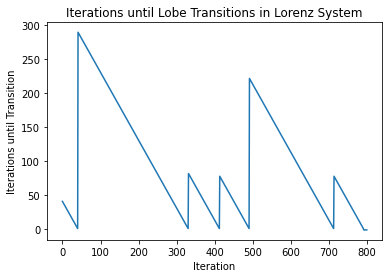

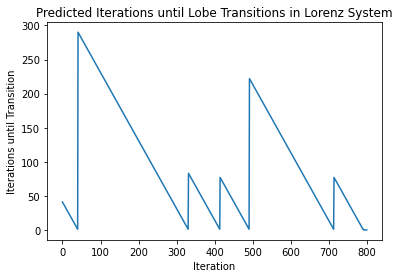

In [ ]:
x0 = 30*np.random.uniform(low=-0.5, high=0.5, size=3)

# Pass in initial conditions and relative/absolute tolerance
y_vals = scipy.integrate.odeint(func = lambda t,x: lorenz(t,x, rho), y0=x0, t=t, rtol=1e-10, atol=1e-11, tfirst=True)

# transition occurs when x goes from positive to negative or vice versa. This only occurs when x(t) + x(t+1) = 0
xs = np.sign(y_vals[:, 0]) # 1 when x is positive and -1 when its negative
transitions = np.where(((xs[:-1] + xs[1:]) == 0 ))[0] # indices where a lobe transition occurs (index right before transition)
dist_from_trans = np.zeros((1, len(t)))

for i, ind in enumerate(transitions):
    if i == 0:
        dist_from_trans[0, :transitions[0] + 1] = list(range(transitions[0] + 1, 0, -1))
    else:
        dist_from_trans[0, transitions[i-1]+1:transitions[i]+1] = list(range(transitions[i] - transitions[i-1], 0, -1))

# all points after last transition are set to -1
dist_from_trans[0, transitions[-1] + 1:] = -1

y_NN = np.zeros(dist_from_trans.shape)
for i in range(dist_from_trans.shape[1]):
    # round answers to either zero or 1
    y_NN[0, i] = int(np.round(model.predict(np.expand_dims(y_vals[i, :], axis=0)) / 100))


#print(y_NN)
    
# If we are training on the 0/1 transition points vs transition times
predicted_dist_from_trans = np.zeros((1, len(t)))
predicted_transitions = (np.where(y_NN == 1))[1]
print(predicted_transitions)
for i, ind in enumerate(predicted_transitions):
    if i == 0:
        predicted_dist_from_trans[0, :predicted_transitions[0] + 1] = list(range(predicted_transitions[0] + 1, 0, -1))
    else:
        predicted_dist_from_trans[0, predicted_transitions[i-1]+1:predicted_transitions[i]+1] = list(range(predicted_transitions[i] - predicted_transitions[ i-1], 0, -1))

# Actual transition times
plt.figure()
plt.plot(dist_from_trans[0, :])
plt.xlabel('Iteration')
plt.ylabel('Iterations until Transition')
plt.title('Iterations until Lobe Transitions in Lorenz System')
plt.show()

# predicted transition times
plt.figure()
plt.plot(predicted_dist_from_trans[0, :])
plt.xlabel('Iteration')
plt.ylabel('Iterations until Transition')
plt.title('Predicted Iterations until Lobe Transitions in Lorenz System')
plt.show()